# 4.3例子  on data vanilla_ice

In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [11]:
#请先安装saxpy
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string

import itertools
from ast import literal_eval
from os.path import exists

import numpy as np
import numpy.fft as fft
import pandas as pd
from joblib import Parallel, delayed
from numba import njit
from scipy.stats import zscore
from tqdm import tqdm

slack = 0.6

file = 'C:\\Users\\jbzp18481526321\\datasets\\ground_truth\\vanilla_ice.csv'
ts_csv= pd.read_csv(file, index_col=0)
ts_origin = ts_csv.values   #csv to numpy
ts = ts_origin

    
    
def extract_sax_sequence(ts, win_size, paa_size, alphabet_size, adaptive_break_points, z_threshold):
    """
    This function applies the sax transformation to a 1-dim time series. Based on saxpy package
    
    """
    if adaptive_break_points:
        sax_sequence = apply_adaptive_sax(ts, win_size, paa_size, alphabet_size, z_threshold)
    else:
        sax_sequence = apply_non_adaptive_sax(ts, win_size, paa_size, alphabet_size, z_threshold)
    return sax_sequence

def apply_non_adaptive_sax(ts, win_size, paa_size, alphabet_size, z_threshold):
    """
    This function applies the sax transformation to a 1-dim time series using adaptive break-points
    
    param ts: 1-time series
        type ts: 1D array
    win_size: size fo the sliding window that generated each sax word
        type win_size: int
    paa_size: number of characters in a single sax word
        type paa_size: int
    alphabet_size: number of unique characters to use in the sax representation
        type alphabet_size: int
    z_threshold: z_threshold for the znorm method from saxpy
        type z_threshold: float
    return: the sax sequence, a list of strings, where each string represents a single sax word
        rtype: list of str
    """
    sax_sequence = []
    cuts = cuts_for_asize(alphabet_size)
    ts_znorm = znorm(ts, z_threshold)              #z_threshold 取 0.01         #先将整个时间序列离散化
    for t in range(0, len(ts) - win_size + 1):
        ts_win = ts_znorm[t:(t+win_size)]          #取窗口
        paa_rep = paa(ts_win, paa_size)            #取平均值   
        sax_word = ts_to_string(paa_rep, cuts)     #离散化
        sax_sequence.append(sax_word)
    return sax_sequence

def apply_adaptive_sax(ts, win_size, paa_size, alphabet_size, z_threshold):
    """
    This function applies the sax transformation to a 1-dim time series using adaptive break-points
    
    """
    sax_sequence = []
    cuts = cuts_for_asize(alphabet_size)   #
    for t in range(0, len(ts) - win_size + 1):            #返回的是len（ts）-L+1个word？
        ts_win = ts[t:(t+win_size)]
        ts_win_znormed = znorm(ts_win, z_threshold)       #分别对窗口作z-norm
        ts_win_znormed_  = list(itertools.chain.from_iterable(ts_win_znormed))
        paa_rep = paa(ts_win_znormed_, paa_size)
        sax_word = ts_to_string(paa_rep, cuts)
        sax_sequence.append(sax_word)
    return sax_sequence

In [12]:
len(ts)

23095

In [14]:
[win_size, paa_size, alphabet_size, z_threshold]=[64,8,10,0.01]
sax_sequence = extract_sax_sequence(ts, 64, 8, 10, True, 0.01)

In [15]:
print(sax_sequence)
len(sax_sequence)

['bigcfhbh', 'cifcgfbi', 'diecgebi', 'didchcci', 'eicdhcci', 'fibdhbei', 'ghbehafi', 'hgbehafh', 'hfbegahh', 'hebgfaig', 'iebgebie', 'idcgccie', 'icdhcdid', 'icehbeic', 'hcfhbfic', 'hcfhbgib', 'gcfhbihb', 'fchgbihb', 'fchfcifc', 'edhddifc', 'deicdiec', 'cfibfidd', 'cfhbgice', 'cfibgibf', 'cghbihbf', 'chgbihbg', 'chfcifcg', 'dhdciebh', 'dhcdidch', 'ehbeicdh', 'fhbfibeh', 'ehagibeh', 'fhahhbeh', 'gfaigbfh', 'gebiebfh', 'hcciebgg', 'hcdidcgf', 'hbeicdgf', 'hbficehe', 'hbgibehd', 'hbhhbfic', 'gbigbfic', 'ecifcghc', 'dciebhhd', 'cdidchge', 'bficdhfe', 'bficehef', 'bgibfhdf', 'bihbficf', 'bigbficg', 'bifbfhcg', 'ciebggdg', 'cidcgfeg', 'eibcgedh', 'eibdgdeh', 'fhaehcei', 'hgaehbei', 'hfaehbei', 'hebehbfi', 'hdbffcgh', 'icbfedgh', 'hbcgedhg', 'hbdgddhf', 'hbehceie', 'hbehceid', 'gbfhbfjc', 'fbfhcgjb', 'ebggdhib', 'dcgfehib', 'cdhfehhb', 'ceheeigb', 'bfhdfifb', 'bficfjdc', 'bficgjcd', 'bfhcgjbf', 'bggdgibg', 'cgfegibg', 'cgedhhbh', 'dgdehfbi', 'ehcehebi', 'ehbeicbi', 'ehbeibci', 'ehbfibeh', 'ff

23032

In [16]:
def extract_modified_bs_sequence(sax_sequence):
    #sax_sequence个数为len（ts）-L+1，但bs_sequence经过删减相邻导致相等
    """
    This functions extracts the modified Behaviour Subsequence (BS) sequence list, which is the original sax word
    sequence where every consecutive pairs of sax words are equal are fused into the same sax word.
    
    sax_sequence: list of original sax words
        type sax_sequence: list of str
    return:
        - bs_sequence (:py:class:`list of str`) - list of modified sax words
        - bs_lengths (:py:class:`list of int`) - list of lengths of each modified sax word
    """
    bs_sequence = []
    bs_lengths = []
    curr_len = 1
    for i in range(len(sax_sequence)):
        curr_bs = sax_sequence[i]
        if i < len(sax_sequence)-1:
            next_bs = sax_sequence[i+1]
        else:
            next_bs = ''
        if curr_bs == next_bs:
            curr_len = curr_len + 1
        else:
            bs_sequence.append(curr_bs)  #直到出现第一次不相等的情形，防止overlapping导致相等
            bs_lengths.append(curr_len)
            curr_len = 1
    return bs_sequence, bs_lengths


#上述得到的bs_lengths并不是指针，为此我们用下面的函数
def generate_bs_pointers(bs_lengths, bs_size):
    """
    It generates the pointers (i.e. time indexes) of each modified sax word into the original time-series data
    
    bs_lengths: list of modified sax words
        type bs_lengths: list of str
    bs_size: window size (in the original time-series) of a single sax word
        type bs_size: int
    return: list of pointers to the original time-series
        rtype: list of list of int
    """
    bs_pointers = []
    start_pointer = 0
    for bs_len_item in bs_lengths:
        end_pointer = start_pointer + bs_size + bs_len_item - 1      #bs_len_item是一个bs连续重复出现的次数 
        pointer_list = list(range(start_pointer, end_pointer))       #方便后续索引，motif的长度变成了window的长度加上bs_len_item的
        bs_pointers.append(pointer_list)                             #得到列表的列表
        start_pointer = start_pointer + bs_len_item
    return bs_pointers  

In [17]:
bs_sequence, bs_lengths = extract_modified_bs_sequence(sax_sequence)
bs_pointer = generate_bs_pointers(bs_lengths, 64)

In [24]:
print(bs_sequence)
print(bs_lengths)

['bigcfhbh', 'cifcgfbi', 'diecgebi', 'didchcci', 'eicdhcci', 'fibdhbei', 'ghbehafi', 'hgbehafh', 'hfbegahh', 'hebgfaig', 'iebgebie', 'idcgccie', 'icdhcdid', 'icehbeic', 'hcfhbfic', 'hcfhbgib', 'gcfhbihb', 'fchgbihb', 'fchfcifc', 'edhddifc', 'deicdiec', 'cfibfidd', 'cfhbgice', 'cfibgibf', 'cghbihbf', 'chgbihbg', 'chfcifcg', 'dhdciebh', 'dhcdidch', 'ehbeicdh', 'fhbfibeh', 'ehagibeh', 'fhahhbeh', 'gfaigbfh', 'gebiebfh', 'hcciebgg', 'hcdidcgf', 'hbeicdgf', 'hbficehe', 'hbgibehd', 'hbhhbfic', 'gbigbfic', 'ecifcghc', 'dciebhhd', 'cdidchge', 'bficdhfe', 'bficehef', 'bgibfhdf', 'bihbficf', 'bigbficg', 'bifbfhcg', 'ciebggdg', 'cidcgfeg', 'eibcgedh', 'eibdgdeh', 'fhaehcei', 'hgaehbei', 'hfaehbei', 'hebehbfi', 'hdbffcgh', 'icbfedgh', 'hbcgedhg', 'hbdgddhf', 'hbehceie', 'hbehceid', 'gbfhbfjc', 'fbfhcgjb', 'ebggdhib', 'dcgfehib', 'cdhfehhb', 'ceheeigb', 'bfhdfifb', 'bficfjdc', 'bficgjcd', 'bfhcgjbf', 'bggdgibg', 'cgfegibg', 'cgedhhbh', 'dgdehfbi', 'ehcehebi', 'ehbeicbi', 'ehbeibci', 'ehbfibeh', 'ff

In [25]:
bs_pointers = generate_bs_pointers(bs_lengths, 64)
print(bs_pointers[0:10])

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], [

In [26]:
from extendedMD.dtwdist import add_distance_vec_to_pattern_dic
from extendedMD.bs import get_bs_subsequences_dic_list
from extendedMD.patterns import find_pattern_center_and_members
from extendedMD.mdl import compute_motif_mdl_cost


def find_all_motif_candidates(ts, bs_seq, bs_len, bs_pointers, r):
    """
    This function finds all the motif candidates of all sizes and saves each motif instance in a dictionary. The result
    is a list of dictionaries.
    
    ts: original 1-d time-series
        type 1d array
    bs_seq: list of ‘modified’ sax words (i.e. BS sequence)
        type list of str
    bs_len: list of the lengths of each BS sequence
        type bs_len: list of int
    bs_pointers: list of pointers to the original time-series
        type bs_pointers: list of list of int
    r: maximum distance to the center of the motif
        type r: float
    return: motif_dic_list
        type: list of dic
    """
    motif_dic_list = []
    subseq_size = 1
    while True:
        bs_subseq_dic_list = get_bs_subsequences_dic_list(ts, bs_seq, bs_pointers, subseq_size) #bs_subseq_dic_list是连续的sax words的列表
        subseq_bs_list = [dic['pattern'] for dic in bs_subseq_dic_list]   #将bs_subseq_dic_list中每一个pattern下面的元素取出放进列表
        subseq_bs_set = [list(item) for item in set(tuple(row) for row in subseq_bs_list)] #set(tuple(row) for row in subseq_bs_list)得到tuple的set
        
        # if there are no repeating patterns of size subseq_size, then there are no more motifs and the loop ends
        if len(subseq_bs_list) == len(subseq_bs_set):
            break
        else:
            for pattern in subseq_bs_set:
                # if the pattern appears only once, then it is not a motif
                if subseq_bs_list.count(pattern) < 2:
                    continue
                else:
                    motif_dic = build_motif_dic_from_pattern(bs_subseq_dic_list, bs_len, pattern, r)
                    # if the pattern only has one member, then it is not a motif
                    if motif_dic == {}:
                        continue
                    else:
                        motif_dic_list.append(motif_dic)
            print('Motif candidates of size {} successfully extracted'.format(subseq_size))   #'Motif candidates of size {} '指的是motif的长度而不是个数
            subseq_size = subseq_size + 1
    return motif_dic_list



def build_motif_dic_from_pattern(bs_subseq_dic_list, bs_len, pattern, r):
    """
    This function builds the motif dictionary related to the pattern given as input
    
    bs_subseq_dic_list: list of dictionaries where each dic represents a single BS subsequence
        bs_subseq_dic_list是连续的sax words构成的列表的列表
        type bs_subseq_dic_list: list of dic
    bs_len: list of the lengths of each BS sequence
        
        type bs_len: list of int
    pattern: list of sax words that made up the pattern
        type pattern: list of str
    r: maximum distance to the center of the motif
        type r: float
    return: motif_dic
        rtype: dic
    """
    initial_pattern_dic_list = [dic for dic in bs_subseq_dic_list if dic['pattern'] == pattern]
    pattern_dic_list = add_distance_vec_to_pattern_dic(initial_pattern_dic_list, r)  #计算距离矩阵，这一步是为了找到下一步的center和members
    center_dic, members_dic_list, mean_dist = find_pattern_center_and_members(pattern_dic_list, r)
    # if the pattern only has one member, then it is not a motif
    if len(members_dic_list) < 2:
        return {}
    else:
        mdl_cost = compute_motif_mdl_cost(members_dic_list, bs_len)
        motif_dic = transform_members_list_into_motif_dic(center_dic, members_dic_list, mdl_cost, round(mean_dist, 2))
    return motif_dic


def transform_members_list_into_motif_dic(center_dic, members_dic_list, mdl_cost, mean_dist):
    """
    This functions creates the dictionary related to the motif composed by the subsequences in members_dic_list
    
    center_dic: dictionary related to the center of motif
        type center_dic: dic
    members_dic_list: list of dictionaries related to all the subsequences that belong to the motif
        type members_dic_list: list of dic
    mdl_cost: MDL cost of the motif (as defined by Tanaka et all)
        type mdl_cost: float
    mean_dist: mean distance between all the pair of motif's members
        type mean_dist: float
    return: motif_dic
        rtype: dic
    """
    members_ts_pointers = [dic['pointers'] for dic in members_dic_list]
    motif_dic = {
        'pattern': center_dic['pattern'],
        'mdl_cost': mdl_cost,
        'mean_dist': mean_dist,
        'members_ts_pointers': members_ts_pointers,
        'center_ts_pointers': center_dic['pointers']
    }
    return motif_dic

In [27]:
motif_dic_list = find_all_motif_candidates(ts, bs_sequence, bs_lengths, bs_pointers, r=10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted


In [28]:
print(motif_dic_list)
len(motif_dic_list)

[{'pattern': ['iiaadffi'], 'mdl_cost': 301378.43, 'mean_dist': 4.21, 'members_ts_pointers': [[15058, 15059, 15060, 15061, 15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071, 15072, 15073, 15074, 15075, 15076, 15077, 15078, 15079, 15080, 15081, 15082, 15083, 15084, 15085, 15086, 15087, 15088, 15089, 15090, 15091, 15092, 15093, 15094, 15095, 15096, 15097, 15098, 15099, 15100, 15101, 15102, 15103, 15104, 15105, 15106, 15107, 15108, 15109, 15110, 15111, 15112, 15113, 15114, 15115, 15116, 15117, 15118, 15119, 15120, 15121], [19197, 19198, 19199, 19200, 19201, 19202, 19203, 19204, 19205, 19206, 19207, 19208, 19209, 19210, 19211, 19212, 19213, 19214, 19215, 19216, 19217, 19218, 19219, 19220, 19221, 19222, 19223, 19224, 19225, 19226, 19227, 19228, 19229, 19230, 19231, 19232, 19233, 19234, 19235, 19236, 19237, 19238, 19239, 19240, 19241, 19242, 19243, 19244, 19245, 19246, 19247, 19248, 19249, 19250, 19251, 19252, 19253, 19254, 19255, 19256, 19257, 19258, 19259, 19260], [19611,

949

In [29]:
mdl_costs = [dic['mdl_cost'] for dic in motif_dic_list]
print(sorted(mdl_costs))

[267717.37, 270173.36, 271929.01, 272551.5, 272656.67, 272781.99, 274464.7, 274653.98, 274693.95, 274869.65, 275035.77, 275173.26, 275215.59, 275331.19, 275588.13, 275824.31, 275912.31, 276019.5, 276119.84, 276376.07, 276478.7, 276892.16, 276967.84, 278728.66, 279280.72, 279584.42, 279587.92, 279666.65, 279690.63, 279849.67, 279910.63, 280204.73, 280227.22, 280266.12, 280313.08, 280484.63, 280646.6, 280713.71, 280933.28, 280936.91, 281236.29, 281684.11, 281792.17, 281979.44, 282381.09, 282527.46, 282620.22, 282633.08, 282756.11, 282927.21, 283009.7, 283042.25, 283139.67, 283278.0, 283766.03, 283897.46, 284155.64, 284158.0, 284319.18, 284323.59, 284323.89, 284524.98, 284666.07, 285036.57, 285175.6, 285215.75, 285488.81, 285753.89, 285840.87, 285922.8, 285930.81, 286037.15, 286040.39, 286062.69, 286112.38, 286535.54, 286707.69, 286718.77, 287106.13, 287113.04, 287188.18, 287226.35, 287230.81, 287369.86, 287371.02, 287444.7, 287457.61, 287482.53, 287490.07, 287490.76, 287491.46, 287573.84

In [71]:
from copy import deepcopy
motif_candidate_list = deepcopy(motif_dic_list)
last_candidate = []
for dic in motif_candidate_list:
    if dic['mdl_cost'] < 275912.31:
        last_candidate.append(dic)

In [74]:
print(len(last_candidate))

16


In [78]:
candidate_center = [dic['center_ts_pointers'] for dic in last_candidate]

In [84]:
def filter_non_trivial_matches(motif_set, m):
    #对窗口长度为m的motif set，排除掉trivial—match的subsequence（删掉位置靠后的一个）
    # filter trivial matches
    non_trivial_matches = []
    last_offset = - m
    for offset in np.sort(motif_set):           #将motif set的index进行排序后，判断相邻两数之间距是否大于m/2
        if offset > last_offset + m / 2:
            non_trivial_matches.append(offset)   
            last_offset = offset

    return np.array(non_trivial_matches)


center_head =[i[0] for i in candidate_center]
center_head = filter_non_trivial_matches(center_head,32)
print(len(center_head))
print(center_head)

12
[ 1424  5930  5967  6374  6806 13729 14630 14839 18980 19393 19936 20000]


In [83]:
center = []
for i in candidate_center:
    if i[0] in center_head:
        center.append(i)
print(len(center))

12


In [94]:
from saxpy.znorm import znorm
import math

motifs_list = []
motifs_num = []
for j in center_head:
    ts_center = znorm(ts[j:j+64])
    r = 3
    motifs = []
    for i in range(len(ts)-64+1):
        ts_win = znorm(ts[i:i+64])
        dist = math.dist(ts_center, ts_win)    
        if dist < r:
            motifs.append(i)
    motifs = filter_non_trivial_matches(motifs,32)      
    motifs_list.append(motifs)
    motifs_num.append(len(motifs))

In [95]:
print(motifs_num)

[28, 20, 29, 34, 15, 18, 30, 33, 34, 35, 17, 22]


In [98]:
motifs_1 = motifs_list[9]
motifs_2 = motifs_list[8]
motifs_3 = motifs_list[3]
motifs_4 = motifs_list[7]

<Figure size 864x432 with 0 Axes>

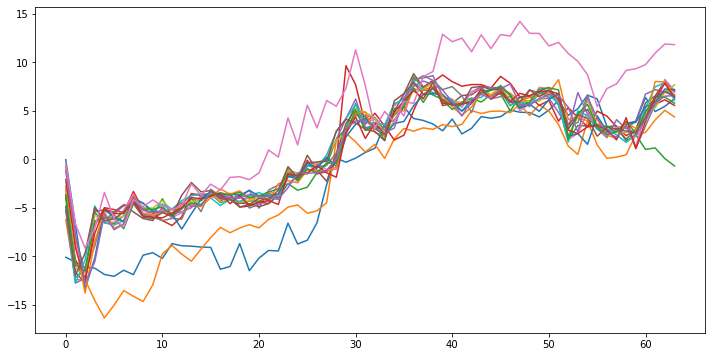

In [110]:
plt.figure(figsize=(12, 6))
import matplotlib.pyplot as plt
for i in motifs_list[10]:
    plt.plot(ts[i:i+64])